In [1]:
## DeepExplain - Keras (TF backend) example
### MNIST with CNN

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Model
from keras import backend as K

import numpy as np
# Import DeepExplain
from deepexplain.tensorflow import DeepExplain

/users/jocelins/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
saved_model_file = "keras2_mnist_cnn_allconv.h5"
model = keras.models.load_model(saved_model_file)
model.summary()
#[print(model.layers[i].output) for i in range(len(model.layers))]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 13, 32)        544       
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               204928    
__________

/users/jocelins/anaconda2/envs/py36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = x_test[:,:,:,None]
x_train = x_train[:,:,:,None]
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)
xs = x_test
print(xs.shape)

(10000, 28, 28, 1)


In [6]:
import tensorflow as tf
import time as time
num_classes = 10
attributions = {}
steps = 20
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    print(input_tensor.shape)
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    print(target_tensor.shape)
    xs = x_test
    print(xs.shape)
    ys = keras.utils.to_categorical(y_test, num_classes)
    #CHECK WITH GROUND TRUTH LABELS
    
    times = {}
    t = time.time()
    
    attributions['deeplift'] = de.explain('deeplift', target_tensor*ys, input_tensor, xs) #attributions for ground truth    
    t = time.time() - t
    times['deeplift'] = t
    print(t)
    t = time.time()
    attributions['integdeeplift_old'] = de.explain('integdeeplift_old', target_tensor*ys, input_tensor, xs, steps=steps) #attributions for ground truth    
    t = time.time() - t
    times['integdeeplift_old'] = t
    print(t)
    t = time.time()
    attributions['intgrad_old'] = de.explain('intgrad_old', target_tensor*ys, input_tensor, xs, steps=steps) #attributions for ground truth    
    t = time.time() - t
    times['intgrads_old'] = t
    print(t)
    
    print("Done!")

(?, 28, 28, 1)
(?, 10)
(10000, 28, 28, 1)
DeepExplain: running "deeplift" explanation method (5)
Model with multiple inputs:  False
0.7591345310211182
DeepExplain: running "integdeeplift_old" explanation method (8)
Model with multiple inputs:  False
36.210633277893066
DeepExplain: running "intgrad_old" explanation method (8)
Model with multiple inputs:  False
8.780924081802368
Done!


In [7]:
pre_softmax_output = K.function([model.layers[0].input],
                                  [model.layers[-2].output])
#results, with xs as input
results = pre_softmax_output([xs])[0]
results_indexed = [results[i][y_test[i]] for i in range(len(y_test))] #results of ground truth labels
results_indexed = np.array(results_indexed)

#results, with reference of all 0s as input
results_ref = pre_softmax_output([np.zeros_like(xs)])[0] #results when input = baseline (all 0's)
results_ref = [results_ref[i][np.argmax(ys[i])] for i in range(len(ys))] #ground truth
results_ref = np.array(results_ref)
results_diff = results_indexed - results_ref
print(results_diff) #must compare to sum of attribs
#'''

[6114.0835 6610.0283 4447.288  ... 7320.908  6010.4844 5558.258 ]


In [8]:
#mean absolute error between results_diff (F(x) - F(x_reference)) and sum of attributions
diffs = {}
for method in attributions.keys():
    diffs[method] = np.abs( results_diff - np.sum(attributions[method], axis=(1, 2, 3)) )
    print(diffs[method])
    print(np.mean(diffs[method]))

[0.00048828 0.         0.00048828 ... 0.00146484 0.00048828 0.00097656]
0.00047757034
[0.00014392 0.0006865  0.00031452 ... 0.00107392 0.00064729 0.00138221]
0.0004696448101537015
[2.41654363 1.6217908  0.08816957 ... 1.47084331 2.25159912 0.76557289]
0.9434397226018273


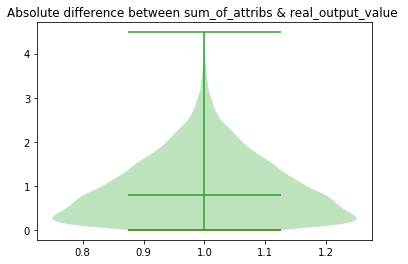

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

for method in diffs.keys():
    #if method != 'intgrad_old':
    plt.violinplot(diffs[method], showmedians=True)

plt.title("Absolute difference between sum_of_attribs & real_output_value ")
plt.show()